#Introduction to Fitting Data to Functions using COVID-19

***IMPORTANT NOTE:*** *This project was created in April 2020, to ensure consistent answers in grading and fit the number of data points was reduced to 88. This means that the data imported ONLY covers between January 21st and April 18th. As such this should NOT be used to make any generalizations.*


---



#Intial setup

In [ ]:
#@title Import libraries
import numpy as np
from datascience import *
import pandas as pd
import io
import requests
import matplotlib.pyplot as plt
import sklearn
from datetime import date, timedelta
import ipywidgets as widgets
from sklearn import linear_model
from scipy.special import expit
import scipy.optimize as opt
import math
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline


def logistic_info(a, b, c): # displays the textbox next to the graph
  text = '\n'.join((
    r'$\mathrm{Logistic \ Equation: \ } \frac{a}{1+e^{-b(x-c)}}}$',
    r'$\mathrm{f(x)}= \frac{%.1f}{1+e^{-%.2f(x-%.2f)}}} $' % (a, b, c, ),
    r'$\mathrm{a}=%.1f$' % (a, ),
    r'$\mathrm{b}=%.3f$' % (b, ),
    r'$\mathrm{c}=%.3f$' % (c, )))
  return text

def logistic(x, a, b, c):
  return a / (1. + np.exp(-b * (x - c)))

def gauss_info(a, b, c): # displays the textbox next to the graph
  text = '\n'.join((
    r'$\mathrm{Gaussian \ Equation: \ } a \cdot e^{-(\frac{(x-b)}{4c})^2}$',
    r'$\mathrm{f(x)}=%.3f \cdot e^{-\frac{(x-%.1f)^2}{2 \cdot %.3f ^2}}$' % (a, b, c, ),
    r'$\mathrm{a}=%.3f$' % (a, ),
    r'$\mathrm{b}=%.1f$' % (b, ),
    r'$\mathrm{c}=%.3f$' % (c, )))
  return text

def gauss(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)




/usr/local/lib/python3.6/dist-packages/datascience/tables.py:17: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)
/usr/local/lib/python3.6/dist-packages/datascience/util.py:10: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)


In [ ]:
#@title Import National data
#@markdown [Github with data](https://github.com/nytimes/covid-19-data)

#@markdown This imports the data from the google sheet to the table `covid_19`


df = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv") #gets the data from the web and puts it in a panda table

covid_19 = Table.from_df(df.head(80)) #transfers panda table into a datascience table
covid_19

date,cases,deaths
2020-01-21,1,0
2020-01-22,1,0
2020-01-23,1,0
2020-01-24,2,0
2020-01-25,3,0
2020-01-26,5,0
2020-01-27,5,0
2020-01-28,5,0
2020-01-29,5,0
2020-01-30,6,0


#Add columns to the table

The table is lacking in a few columns: Days since first case, change in cases per day, change in deaths between days.

##Create a column for days since 1/21
As you may notice, there is not a column for days since the first reported national case, add a 

In [ ]:
array_of_days = np.arange(covid_19.num_rows)

covid_19 = covid_19.with_column("Days since first case", array_of_days)
covid_19

date,cases,deaths,Days since first case
2020-01-21,1,0,0
2020-01-22,1,0,1
2020-01-23,1,0,2
2020-01-24,2,0,3
2020-01-25,3,0,4
2020-01-26,5,0,5
2020-01-27,5,0,6
2020-01-28,5,0,7
2020-01-29,5,0,8
2020-01-30,6,0,9


##Change in cases per day

You will need to use the function [np.diff()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.diff.html)

`np.diff()` takes an array and returns the value of the difference, for example:


**Input**

`example_array = np.array([0, 5, 10, 12, 7, 9])` 

`np.diff(example)`

**Output**

`array([ 5,  5,  2, -5,  2])`

**Important note:** *you will need to add a zero to the beggining of your array. That is done with* `np.insert()`


In [ ]:
diff_cases = np.diff(covid_19["cases"]) #see above

#edit only the above
diff_cases = np.insert(diff_cases, 0, 0)
covid_19 = covid_19.with_column("Change in cases", diff_cases)
covid_19

date,cases,deaths,Days since first case,Change in cases
2020-01-21,1,0,0,0
2020-01-22,1,0,1,0
2020-01-23,1,0,2,0
2020-01-24,2,0,3,1
2020-01-25,3,0,4,1
2020-01-26,5,0,5,2
2020-01-27,5,0,6,0
2020-01-28,5,0,7,0
2020-01-29,5,0,8,0
2020-01-30,6,0,9,1


##Change in deaths per day

In [ ]:
diff_deaths = np.diff(covid_19["deaths"]) #see above

#edit above
diff_deaths = np.insert(diff_deaths, 0, 0)
covid_19 = covid_19.with_column("Change in deaths", diff_deaths)
covid_19

date,cases,deaths,Days since first case,Change in cases,Change in deaths
2020-01-21,1,0,0,0,0
2020-01-22,1,0,1,0,0
2020-01-23,1,0,2,0,0
2020-01-24,2,0,3,1,0
2020-01-25,3,0,4,1,0
2020-01-26,5,0,5,2,0
2020-01-27,5,0,6,0,0
2020-01-28,5,0,7,0,0
2020-01-29,5,0,8,0,0
2020-01-30,6,0,9,1,0


##Reorder columns

As you may have noticed, the columns are a bit messed up (`move_column` *is not working*). Run the cell to reorder the columns.

In [ ]:
#@markdown **Run this cell block**

covid_19 = covid_19.move_to_start("cases")
covid_19 = covid_19.move_to_start("Days since first case")
covid_19 = covid_19.move_to_start("date")

covid_19 = covid_19.move_to_end("Change in cases")
covid_19 = covid_19.move_to_end("deaths")
covid_19 = covid_19.move_to_end("Change in deaths")


covid_19

date,Days since first case,cases,Change in cases,deaths,Change in deaths
2020-01-21,0,1,0,0,0
2020-01-22,1,1,0,0,0
2020-01-23,2,1,0,0,0
2020-01-24,3,2,1,0,0
2020-01-25,4,3,1,0,0
2020-01-26,5,5,2,0,0
2020-01-27,6,5,0,0,0
2020-01-28,7,5,0,0,0
2020-01-29,8,5,0,0,0
2020-01-30,9,6,1,0,0


#Viewing the data

Before attempting to predict the data, display it.

##Plot Number Infected 

Inset the x and y into the variable below

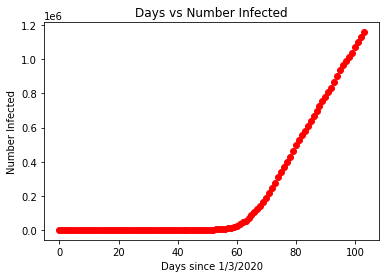

In [ ]:
x = covid_19["Days since first case"]
y = covid_19["cases"]

#only change the above
plt.plot(x, y, "ro")
plt.xlabel('Days since 1/3/2020')
plt.ylabel('Number Infected')
plt.title("Days vs Number Infected")

plt.show()

##Plot Rate of Infection

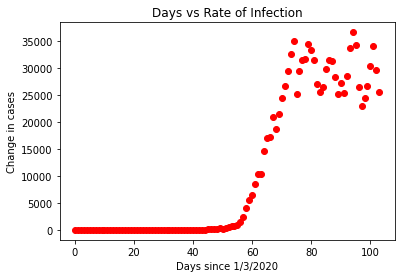

In [ ]:
x = covid_19["Days since first case"]
y = covid_19["Change in cases"]

#only change the above
plt.plot(x, y, "ro")
plt.xlabel('Days since 1/3/2020')
plt.ylabel('Change in cases')
plt.title("Days vs Rate of Infection")

plt.show()

#Fitting the Data

The next section will discuss fitting data to an equation using `opt.curve_fit()` and variables to make conclusions and predictions.

##Best Fit Curve of Infections

The number of infections can be modeled by a logitic curve that looks like the following:

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1200px-Logistic-curve.svg.png)


It is ideal for modeling infections as it has at first exponential growth, but it at some point slows

Here is the equation for a logistic curve:
# $\frac{a}{1+e^{-b(x-c)}}$

It has been made into a function callable by `logistic` which takes four variables. You can see this with the example code below



```
def logistic(x, a, b, c):
  return a / (1. + np.exp(-b * (x - c)))
```

To find the variables that best the equation, the function `opt.curve_fit()`. It returns the best fitting variables in some, *but not all*, cases. It has been inserted below.

put the x and y below, and try using one of the methods to find the variables

In [ ]:
x = covid_19["Days since first case"]
y = covid_19["cases"]

In [ ]:
#@title Manual Variable Finding
#@markdown *Try manually finding variables before using the automatic solver*

a =  #@param {type:"number"}
b =  #@param {type:"number"}
c =  #@param {type:"number"}

y_pred = logistic(x, a, b, c) # this will put the array through the function along with the fitted variables


plt.xlabel('Days since 1/3/2020')
plt.ylabel('Number Infected')
plt.title("Days vs Number Infected Fitted")
plt.plot(x, y, 'o') #This plots the known points as dots
plt.plot(x, y_pred, '-') #this plots the predicted points as a line
plt.text(np.max(x)+10, np.max(y)-150000, logistic_info(a, b, c), verticalalignment='top') #this provides a helpful textbox for funtion information
plt.show()

print("R2 score of: %.7f" % sklearn.metrics.r2_score(y, y_pred))
print("Mean absolute error:  %.2f" % sklearn.metrics.mean_absolute_error(y, y_pred))

SyntaxError: ignored

In [ ]:
#@title Interactive Variable Finding
#@markdown *This launches an interactive pywidget.*


def interactive(a,b,c):
  y_pred = logistic(x, a, b, c) # this will put the array through the function along with the fitted variables


  plt.xlabel('Days since 1/3/2020')
  plt.ylabel('Number Infected')
  plt.title("Days vs Number Infected Fitted")
  plt.plot(x, y, 'o') #This plots the known points as dots
  plt.plot(x, y_pred, '-') #this plots the predicted points as a line
  plt.text(np.max(x)+10, np.max(y)-150000, logistic_info(a, b, c), verticalalignment='top') #this provides a helpful textbox for funtion information
  plt.show()

  print("R2 score of: %.7f" % sklearn.metrics.r2_score(y, y_pred))
  print("Mean absolute error:  %.2f" % sklearn.metrics.mean_absolute_error(y, y_pred))

interact(interactive, a=(700000,900000), b=(0, 2, 0.001), c=(60, 100))

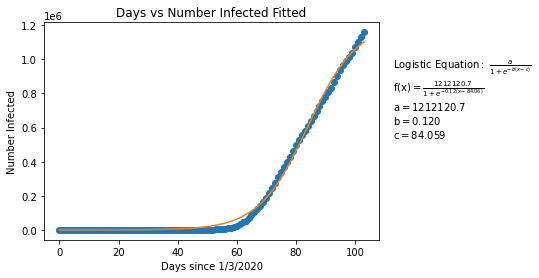

R2 score of: 0.9965920
Mean absolute error:  14524.56


In [ ]:
#@title Automatic Variable Finding
#@markdown This uses `opt.curve_fit()` to find the best fitting variables.

(a_, b_, c_), _ = opt.curve_fit(logistic, x, y) #Finds the variablesthat fit best
y_pred = logistic(x, a_, b_, c_) # this will put the array through the function along with the fitted variables


plt.xlabel('Days since 1/3/2020')
plt.ylabel('Number Infected')
plt.title("Days vs Number Infected Fitted")
plt.plot(x, y, 'o') #This plots the known points as dots
plt.plot(x, y_pred, '-') #this plots the predicted points as a line
plt.text(np.max(x)+10, np.max(y)-150000, logistic_info(a_, b_, c_), verticalalignment='top') #this provides a helpful textbox for funtion information
plt.show()

print("R2 score of: %.7f" % sklearn.metrics.r2_score(y, y_pred))
print("Mean absolute error:  %.2f" % sklearn.metrics.mean_absolute_error(y, y_pred))

###Questions about Fitted Infection Function

**Using that fitted variable predict approximatley how many people will be diagnosed nationwide:**

*You answer here*

**Can you predict when the infections will be within 10% of the upper limit:**

*Your answer here*

##Best Fit Curve Rate of Infection

Find a solution with an $R^2$ greater than 0.9

----

The rate of infection can be modeled by a gaussian curve with the form: $ae^{-\frac{x-\mu}{4\sigma}^2}$

The rate of infections can not be tuned using `opt.fit()`. So you will need to try and adjust the variables on your own (or using math)

 
*   **Amplitude**
  *  This is represented by $a$ in the equation and `gauss_amp` in the code. It is also the peak of the   
*   **Mean**
  *  Mean is represented by $\mu$ in the equation, and `gauss_mean` in the code. It also happens to be the location of the peak of the equation
*  **Standard Deviation**
  *  Standard deviation is represented by $\sigma$ in the equation and `gauss_std` in the code. The standard deviation determines the spread of the bell curve, the larger the number the wider the curve.
----



In [ ]:
x = covid_19["Days since first case"]
y = covid_19["Change in cases"]

#CHANGE THIS AND RUN IT BEFORE CONTINUING!!!!

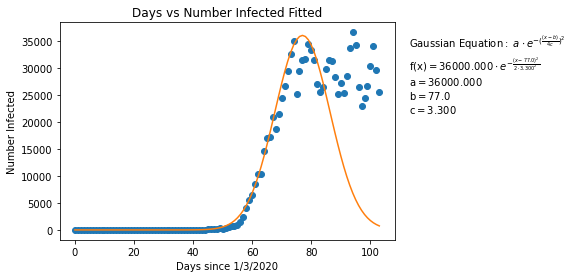

R2 score of: 0.5291017
Mean absolute error:  4252.08


In [ ]:
#@title Fitting with variables
#@markdown Fit using variables



gauss_amp = 36000 #@param {type:"number"}
gauss_mean = 77 #@param {type:"number"}
gauss_std = 3.3 #@param {type:"number"}


#edit the above



y_pred = gauss(x, gauss_amp, gauss_mean, gauss_std) # this will put the array through the function along with the fitted variables


plt.xlabel('Days since 1/3/2020')
plt.ylabel('Number Infected')
plt.title("Days vs Number Infected Fitted")
plt.plot(x, y, 'o') #This plots the known points as dots
plt.plot(x, y_pred, '-') #this plots the predicted points as a line
plt.text(np.max(x)+10, np.max(y), gauss_info(gauss_amp, gauss_mean, gauss_std), verticalalignment='top') #this provides a helpful textbox for funtion information
plt.show()

print("R2 score of: %.7f" % sklearn.metrics.r2_score(y, y_pred))
print("Mean absolute error:  %.2f" % sklearn.metrics.mean_absolute_error(y, y_pred))

In [ ]:
#@title Interactive Fitting
#@markdown This will help you fit the curve with an adgustable slider


def interactive(a,b,c):
  gauss_amp = a
  gauss_mean = b
  gauss_std = c
  
  y_pred = gauss(x, gauss_amp, gauss_mean, gauss_std) # this will put the array through the function along with the fitted variables


  plt.xlabel('Days since 1/3/2020')
  plt.ylabel('Number Infected')
  plt.title("Days vs Number Infected Fitted")
  plt.plot(x, y, 'o') #This plots the known points as dots
  plt.plot(x, y_pred, '-') #this plots the predicted points as a line
  plt.text(np.max(x)+10, np.max(y), gauss_info(gauss_amp, gauss_mean, gauss_std), verticalalignment='top') #this provides a helpful textbox for funtion information
  plt.show()

  print("R2 score of: %.7f" % sklearn.metrics.r2_score(y, y_pred))
  print("Mean absolute error:  %.2f" % sklearn.metrics.mean_absolute_error(y, y_pred))

interact(interactive, a=(30000,40000), b=(60,100, 0.5), c=(0,7,0.1))

####Possible solution
*Open this block for a potential solution.*


Variables set to:
```
gauss_amp = 36000
gauss_mean = 77
gauss_std = 3.3
```
On April 18th this had:

```
R2 score of: 0.9618715
Mean absolute error:  1035.88
```


###Questions about Fitted Function

**When will there be less than 10,000 new reported cases:**

*First calculate how many days, then put the number of days into the code block below to see a date*

In [ ]:
days_since = 12 #@param {type:"integer"}

intial_date = date(2020, 1, 3)
new_date = intial_date + timedelta(days=days_since)

print("There will be less than 10,000 new reported cases on: ", new_date)


**When will 90% of cases be reported:**

*Your answer here*

**

**There is an 11.3% hospitilazation rate of COVID-19 (according to:** [*CDC.gov*](https://www.cdc.gov/coronavirus/2019-ncov/covid-data/covidview/index.html) and [*USA Today*](https://www.usatoday.com/story/money/2020/04/17/states-with-the-highest-number-of-covid-19-cases/111552340/)) **and there are**

#Fitting Death statistics

The next section uses the death statistics, if you feel uncomfortable with the topic there is **no obligation** to continue. 

If you would like to continue, please check the box below.

In [ ]:
I_Am_Continuing = False #@param {type:"boolean"}

##Best Fit Curve Number of Deaths

In [ ]:
x = covid_19["Days since first case"]
y = covid_19["deaths"]

In [ ]:
#@title Manual Variable Finding
#@markdown *Try manually finding variables before using the automatic solver*

a =  42911 #@param {type:"number"}
b = 0.197 #@param {type:"number"}
c =  81.453 #@param {type:"number"}

y_pred = logistic(x, a, b, c) # this will put the array through the function along with the fitted variables


plt.xlabel('Days since 1/3/2020')
plt.ylabel('Number Dead')
plt.title("Days vs Number Dead Fitted")
plt.plot(x, y, 'o') #This plots the known points as dots
plt.plot(x, y_pred, '-') #this plots the predicted points as a line
plt.text(np.max(x)+10, np.max(y)-1500, logistic_info(a, b, c_), verticalalignment='top') #this provides a helpful textbox for funtion information
plt.show()

print("R2 score of: %.7f" % sklearn.metrics.r2_score(y, y_pred))
print("Mean absolute error:  %.2f" % sklearn.metrics.mean_absolute_error(y, y_pred))

In [ ]:
#@title Interactive Variable Finding
#@markdown *This launches an interactive pywidget.*


def interactive(a,b,c):
  y_pred = logistic(x, a, b, c) # this will put the array through the function along with the fitted variables

  plt.xlabel('Days since 1/3/2020')
  plt.ylabel('Number Dead')
  plt.title("Days vs Number Dead Fitted")
  plt.plot(x, y, 'o') #This plots the known points as dots
  plt.plot(x, y_pred, '-') #this plots the predicted points as a line
  plt.text(np.max(x)+10, np.max(y)-1500, logistic_info(a, b, c_), verticalalignment='top') #this provides a helpful textbox for funtion information
  plt.show()

  print("R2 score of: %.7f" % sklearn.metrics.r2_score(y, y_pred))
  print("Mean absolute error:  %.2f" % sklearn.metrics.mean_absolute_error(y, y_pred))

interact(interactive, a=(30000, 50000), b=(0,1, 0.0001), c=(50, 100))

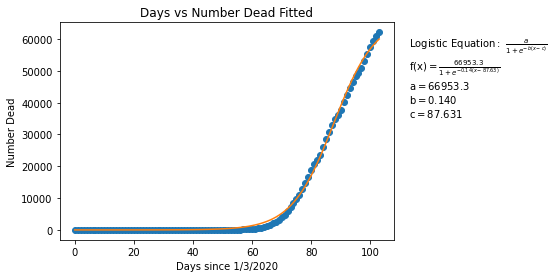

R2 score of: 0.9980677
Mean absolute error:  533.87


In [ ]:
#@title Automatic Variable Finding
#@markdown This uses `opt.curve_fit()` to find the best fitting variables.


(a_, b_, c_), _ = opt.curve_fit(logistic, x, y) 
y_pred = logistic(x, a_, b_, c_) # this will put the array through the function along with the fitted variables


plt.xlabel('Days since 1/3/2020')
plt.ylabel('Number Dead')
plt.title("Days vs Number Dead Fitted")
plt.plot(x, y, 'o') #This plots the known points as dots
plt.plot(x, y_pred, '-') #this plots the predicted points as a line
plt.text(np.max(x)+10, np.max(y)-1500, logistic_info(a_, b_, c_), verticalalignment='top') #this provides a helpful textbox for funtion information
plt.show()

print("R2 score of: %.7f" % sklearn.metrics.r2_score(y, y_pred))
print("Mean absolute error:  %.2f" % sklearn.metrics.mean_absolute_error(y, y_pred))

**How many people are predicted to according to the equation:**

*Your answer here*

##Best Fit Curve Rate of Deaths

Find a solution with an $R^2$ greater than 0.9

Edit the code block below to define an x and y variable for the equation

In [ ]:
x = covid_19["Days since first case"]
y = covid_19["Change in deaths"]

In [ ]:
#@title Fitting with numbers
#@markdown Use this cell to add 

gauss_amp = 2500 #@param {type:"number"}
gauss_mean = 86 #@param {type:"number"}
gauss_std = 3.3 #@param {type:"number"}


#edit the above

def gauss(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)


y_pred = gauss(x, gauss_amp, gauss_mean, gauss_std) # this will put the array through the function along with the fitted variables


plt.xlabel('Days since 1/3/2020')
plt.ylabel('New Deaths')
plt.title("Days vs New Deaths Fitted")
plt.plot(x, y, 'o') #This plots the known points as dots
plt.plot(x, y_pred, '-') #this plots the predicted points as a line
plt.text(np.max(x)+10, np.max(y), gauss_info(gauss_amp, gauss_mean, gauss_std), verticalalignment='top') #this provides a helpful textbox for funtion information
plt.show()

print("R2 score of: %.7f" % sklearn.metrics.r2_score(y, y_pred))
print("Mean absolute error:  %.2f" % sklearn.metrics.mean_absolute_error(y, y_pred))

In [ ]:
#@title Interactive Fitting
#@markdown Use this cell block to fit the curve to the data.
def interactive(a,b,c):
  gauss_amp = a
  gauss_mean = b
  gauss_std = c

  y_pred = gauss(x, gauss_amp, gauss_mean, gauss_std) # this will put the array through the function along with the fitted variables

  plt.xlabel('Days since 1/3/2020')
  plt.ylabel('New Deaths')
  plt.title("Days vs New Deaths Fitted")
  plt.plot(x, y, 'o') #This plots the known points as dots
  plt.plot(x, y_pred, '-') #this plots the predicted points as a line
  plt.text(np.max(x)+10, np.max(y), gauss_info(gauss_amp, gauss_mean, gauss_std), verticalalignment='top') #this provides a helpful textbox for funtion information
  plt.show()

  print("R2 score of: %.7f" % sklearn.metrics.r2_score(y, y_pred))
  print("Mean absolute error:  %.2f" % sklearn.metrics.mean_absolute_error(y, y_pred))


interact(interactive, a=(2000,3000), b=(60,100), c=(0,7, 0.1))

interactive(children=(IntSlider(value=2500, description='a', max=3000, min=2000), IntSlider(value=80, descript…

<function __main__.interactive>

####Possible solution
*Open this block for a potential solution.*


Variables set to:
```
gauss_amp = 2500
gauss_mean = 87
gauss_std = 3.9
```
On April 18th this had:

```
R2 score of: 0.9517000
Mean absolute error:  59.69
```


###Questions about Rate of Deaths

**Using the mean you found in the rate of reported infections and the one above. Can you predict how long after being diagnosed a patient is recovering or critical?**

*Your answer here*

#Afterwards

These are once again completley optional questions.

**Do you feel that analyzing the data has given you a new understanding of the current state of affairs?**

*Your answer here*